# Pruebas

+ En las definiciones de las funciones en LennardGas ya no se suponen valores predeterminados para los parámetros, siempre hay que darlos explicitamente para realizar pruebas.

In [15]:
using PyCall, PyPlot , Distributions
@pyimport matplotlib.animation as anim

In [16]:
push!(LOAD_PATH, pwd())
using LennardGas

In [17]:
#Parámetros
r_c = 2.5
L   = r_c * 100
cajitas = 2^60
h = 0.005;

#### Condición inicial gaussiana

In [18]:
particulas = 50;

In [19]:
#Condición inicial (en Float64)
inicial = rand(Normal(L/2, 5.0), 3*particulas)
segundo = fluctuacion_gaussiana(inicial, 0.0, 0.5)

#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas);

In [20]:
@time vector_fuerzas(X0 , L, cajitas, r_c, h);

  0.595076 seconds (2.11 M allocations: 134.102 MB, 22.72% gc time)


In [21]:
@time X2 = paso_verlet(X0, X1, L, cajitas, r_c, h);

  0.447157 seconds (2.01 M allocations: 129.972 MB, 28.82% gc time)


In [22]:
#Compilación de evolución
pasos = 5 
@time registro = evolucion(X0, X1, pasos, L, cajitas, r_c, h);

  2.422915 seconds (10.09 M allocations: 652.781 MB, 26.76% gc time)


### Prueba de reversibilidad

In [23]:
pasos = 5
@time prueba1 = prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h);

El proceso fue reversible.
  4.486771 seconds (20.02 M allocations: 1.268 GB, 28.13% gc time)


## Graficando

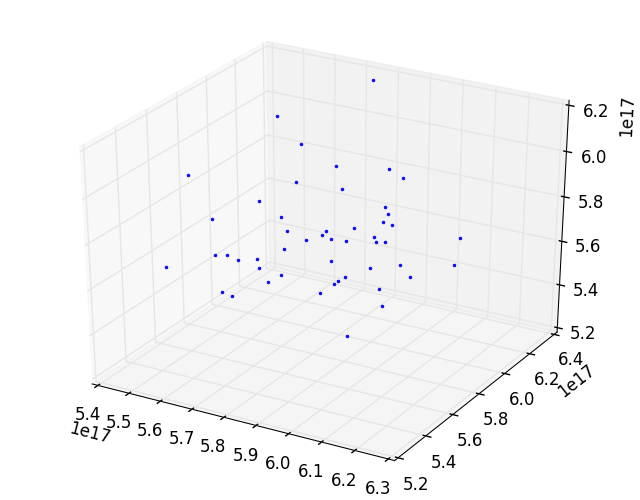

In [24]:
fotograma(registro, 1)

### Distribución inicial cúbica

In [32]:
pasos = 20

# Incrementando las partículas se nota que los "arboles" sí funcionan.
raiz_cub_part = 3 
@show particulas = raiz_cub_part^3

#Condicion inicial (en Float64)
inicial = cubito(raiz_cub_part, [L/2,L/2,L/2], L/4)
segundo = fluctuacion_gaussiana(inicial, 0.0, 1.0)

#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas)
@time registro = evolucion(X0, X1, pasos, L, cajitas, r_c, h);

particulas = raiz_cub_part ^ 3 = 27
  9.368757 seconds (40.00 M allocations: 2.533 GB, 28.16% gc time)


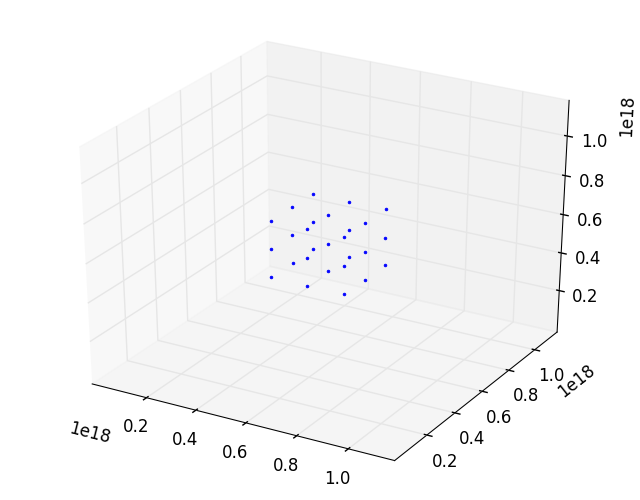

(1,1152921504606846976)

In [33]:
tiempo_inicial = 1
fotograma(registro, tiempo_inicial; cajitas = 2^60)

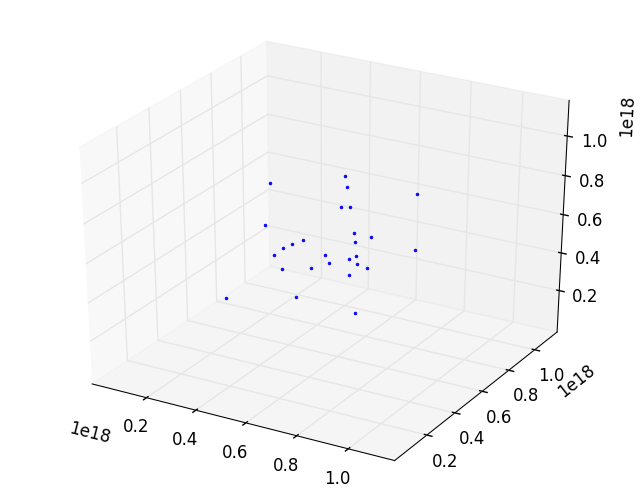

(1,1152921504606846976)

In [34]:
tiempo_final = size(registro, 1)
fotograma(registro, tiempo_final; cajitas = 2^60)

**Ejemplo animación:** https://github.com/JuliaLang/IJulia.jl/issues/107

  6.806098 seconds (3.77 k allocations: 198.625 KB)


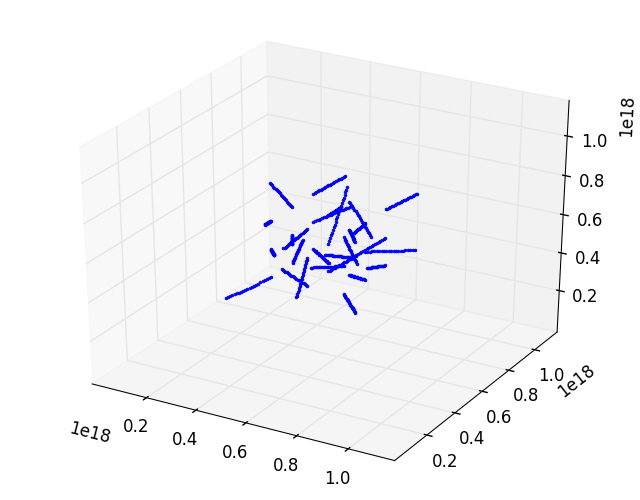

(1,1152921504606846976)

In [42]:
paso_temp = size(registro, 1)
fig = figure()
rollo = []
@time for t in 1:paso_temp
    #fg = fotograma(registro, t)
    x,y,z = organizador(registro,t)
    fg = plot3D(x, y, z, "b.", markersize = 4.0)
    push!(rollo, collect(fg))
end

xlim(1,cajitas)
ylim(1,cajitas)
zlim(1,cajitas)

In [46]:
typeof(rollo)

Array{Any,1}

In [47]:
@time ani = anim.ArtistAnimation(fig, rollo, interval = 100, blit = true, repeat = true, repeat_delay = 2000)
ani[:save]("cubito.mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"]);

  0.053671 seconds (163 allocations: 4.750 KB)


##### Todo en una función: animador

### Animando la ida y la vuelta
**Esto toma mucho tiempo**

pasos = 300

raiz_cub_part = 17
@show particulas = raiz_cub_part^3

#Condicion inicial (en Float64)
inicial = cubito(raiz_cub_part, [L/2,L/2,L/2], L/4)
segundo = fluctuacion_gaussiana(inicial, 0.0, 1.0)

#Condición inicial (en Int64)
X0 = flotante_a_entero(inicial, L, cajitas)
X1 = flotante_a_entero(segundo, L, cajitas)
@time registro_ida, registro_vuelta = prueba_reversible(X0, X1, pasos, L, cajitas, r_c, h);

registro_maestro = vcat(registro_ida, registro_vuelta) #Esto podría agregarse a prueba_reversible
@time animador(registro_maestro, "particulas_$particulas\_pasos_$pasos")

**Proyecto gravitacion Capitán Sanders**

Basado en: https://github.com/dpsanders/fisica_computacional/blob/master/como_animar.ipynb